In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
# import Sequential from the keras models module
from keras.models import Sequential

# import Dense, Dropout, Flatten, Conv2D, MaxPooling2D from the keras layers module
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [2]:
from keras.applications import NASNetMobile
#from keras.applications.nasnet import preprocess_input

In [8]:
folder = os.listdir('image_arrays')
folder

['X_color', 'y_color']

In [11]:
folderX = os.listdir('image_arrays/' + folder[0])
foldery = os.listdir('image_arrays/' + folder[1])
print(folderX, foldery)

['X0_color.npy', 'X1_color.npy', 'X2_color.npy', 'X3_color.npy', 'X4_color.npy', 'X5_color.npy', 'X6_color.npy', 'X7_color.npy', 'X8_color.npy', 'X9_color.npy'] ['y0_color.npy', 'y1_color.npy', 'y2_color.npy', 'y3_color.npy', 'y4_color.npy', 'y5_color.npy', 'y6_color.npy', 'y7_color.npy', 'y8_color.npy', 'y9_color.npy']


In [19]:
file1 = folderX[0]
file2 = folderX[1]
X0 = np.load('image_arrays/' + folder[0] + '/'+ file1, allow_pickle=False)
X1 = np.load('image_arrays/' + folder[0] + '/'+ file2, allow_pickle=False)

X1.shape
print(file1, file2)

X0_color.npy X1_color.npy


In [20]:
X0.shape, X1.shape

((580, 224, 224, 3), (580, 224, 224, 3))

In [25]:
X = np.append(X, X1, axis=0)

In [31]:
len(folderX)

10

In [32]:
num_chunks = len(folderX)
for i in range(num_chunks):
    Xfile = folderX[i]
    yfile = foldery[i]
    print(i, Xfile, yfile)
    Xi = np.load('image_arrays/' + folder[0] + '/'+ Xfile, allow_pickle=False)
    yi = np.load('image_arrays/' + folder[1] + '/'+ yfile, allow_pickle=False)

    if i==0:
        X = Xi
        y = yi
    else:
        X = np.append(X,Xi, axis=0)
        y = np.append(y,yi,axis=0) 

0 X0_color.npy y0_color.npy
1 X1_color.npy y1_color.npy
2 X2_color.npy y2_color.npy
3 X3_color.npy y3_color.npy
4 X4_color.npy y4_color.npy
5 X5_color.npy y5_color.npy
6 X6_color.npy y6_color.npy
7 X7_color.npy y7_color.npy
8 X8_color.npy y8_color.npy
9 X9_color.npy y9_color.npy


In [33]:
X.shape, y.shape

((5800, 224, 224, 3), (5800,))

1450
1


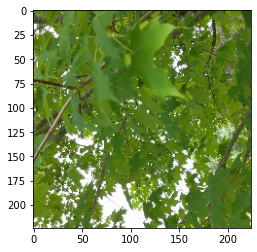

In [36]:
i = int(0.25*X.shape[0])
print(i)
print(y[i])
plt.imshow(X[i])
plt.show()

4466
0


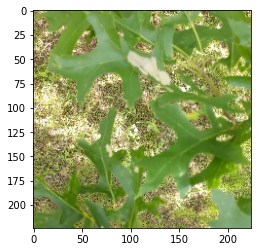

In [35]:
i = int(0.77*X.shape[0])
print(i)
print(y[i])
plt.imshow(X[i])
plt.show()

In [37]:
X = X.reshape((-1,224,224,3))
y = y.reshape((-1,1))
X.shape, y.shape

((5800, 224, 224, 3), (5800, 1))

In [7]:
# split out evaluation sets (x_eval and y_eval)
x_interim, x_eval, y_interim, y_eval = train_test_split(X,
                                           y,
                                           test_size=0.2,
                                           random_state=52)

# split remaining data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_interim,
                                           y_interim,
                                           test_size=0.4,
                                           random_state=52)

# examine number of samples in train, test, and validation sets
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_eval.shape[0], 'eval samples')

x_train shape: (921, 224, 224, 3)
921 train samples
615 test samples
384 eval samples


In [28]:
pre_model = NASNetMobile(input_shape=(224,224,3), include_top=False, 
             weights='imagenet', input_tensor=None, pooling='avg')
pre_model.trainable = False

In [14]:
input_shape = x_train.shape[1:]

In [29]:
# set model constants
num_classes = 1
# define model as Sequential
model = Sequential()
model.add(pre_model)
# prediction layers
model.add(Dense(num_classes, activation='sigmoid', name='preds'))
# show model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 1056)              4269716   
_________________________________________________________________
preds (Dense)                (None, 1)                 1057      
Total params: 4,270,773
Trainable params: 1,057
Non-trainable params: 4,269,716
_________________________________________________________________


In [30]:
model.compile(
    # set the loss as binary_crossentropy
    loss='binary_crossentropy',
    # set the optimizer as stochastic gradient descent
    optimizer=keras.optimizers.SGD(lr=0.001),
    # set the metric as accuracy
    metrics=['accuracy']
)

In [ ]:
# model = keras.models.Sequential()
# model.add(model)
# model.add(keras.layers.Dense(1, activation='softmax'))
# model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [35]:
model.fit(
    x_train[:920],
    y_train[:920],
    batch_size=20,
    epochs=20,
    verbose=1,
    validation_data=(x_test, y_test)
)

Epoch 1/20
46/46 [==============================] - 101s 2s/step - loss: 0.4218 - accuracy: 0.8543 - val_loss: 0.4351 - val_accuracy: 0.8407
Epoch 2/20
46/46 [==============================] - 97s 2s/step - loss: 0.4116 - accuracy: 0.8554 - val_loss: 0.4248 - val_accuracy: 0.8439
Epoch 3/20
46/46 [==============================] - 96s 2s/step - loss: 0.4031 - accuracy: 0.8587 - val_loss: 0.4166 - val_accuracy: 0.8455
Epoch 4/20
46/46 [==============================] - 97s 2s/step - loss: 0.3945 - accuracy: 0.8663 - val_loss: 0.4111 - val_accuracy: 0.8504
Epoch 5/20
46/46 [==============================] - 97s 2s/step - loss: 0.3872 - accuracy: 0.8641 - val_loss: 0.4030 - val_accuracy: 0.8472
Epoch 6/20
46/46 [==============================] - 96s 2s/step - loss: 0.3803 - accuracy: 0.8707 - val_loss: 0.3960 - val_accuracy: 0.8553
Epoch 7/20
46/46 [==============================] - 96s 2s/step - loss: 0.3739 - accuracy: 0.8717 - val_loss: 0.3897 - val_accuracy: 0.8569
Epoch 8/20
46/46 [=

In [36]:
# test model on evaluation set
model.evaluate(x_eval, y_eval, verbose=2)

12/12 - 16s - loss: 0.3340 - accuracy: 0.8750


[0.3339758813381195, 0.875]

In [33]:
import h5py

In [37]:
# json_model = model.to_json()#save the model architecture to JSON file
# with open('model_arch.json', 'w') as json_file:
#     json_file.write(json_model)#saving the weights of the model
# model.save_weights('model_weights.h5')